In [1]:
!pip install datasets torchvision --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.3 MB/s eta 0:00:00


In [1]:
!pip install -U datasets huggingface_hub fsspec


In [2]:
import torch
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 38.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.15MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.60MB/s]


In [3]:
from datasets import load_dataset
from torchvision import transforms
import torch

dataset = load_dataset("mnist", split="train", streaming=True)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

X_list, y_list = [], []

for i, sample in enumerate(dataset):
    img_tensor = transform(sample['image']).view(-1)
    X_list.append(img_tensor)
    y_list.append(sample['label'])
    if i >= 9999:
        break

X_tensor = torch.stack(X_list)
y_tensor = torch.tensor(y_list)

print("X shape:", X_tensor.shape)
print("y shape:", y_tensor.shape)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

X shape: torch.Size([10000, 784])
y shape: torch.Size([10000])


In [4]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 256
train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=batch_size, shuffle=True)


In [5]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return latent, reconstructed


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 10
for epoch in range(epochs):
    total_loss = 0
    model.train()
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        latent, output = model(batch_X)
        loss = criterion(output, batch_X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1, Loss: 1.1882
Epoch 2, Loss: 0.9254
Epoch 3, Loss: 0.9254
Epoch 4, Loss: 0.9252
Epoch 5, Loss: 0.9255
Epoch 6, Loss: 0.9254
Epoch 7, Loss: 0.9254
Epoch 8, Loss: 0.9254
Epoch 9, Loss: 0.9256
Epoch 10, Loss: 0.9255


In [7]:
model.eval()
embeddings = []
true_labels = []

with torch.no_grad():
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        latent, _ = model(batch_X)
        embeddings.append(latent.cpu().numpy())
        true_labels.append(batch_y.numpy())

import numpy as np
embeddings = np.vstack(embeddings)
true_labels = np.concatenate(true_labels)


In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

print(f"Silhouette Score: {silhouette_score(embeddings, cluster_labels):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(embeddings, cluster_labels):.4f}")


Silhouette Score: 0.5158
Davies-Bouldin Index: 0.5271


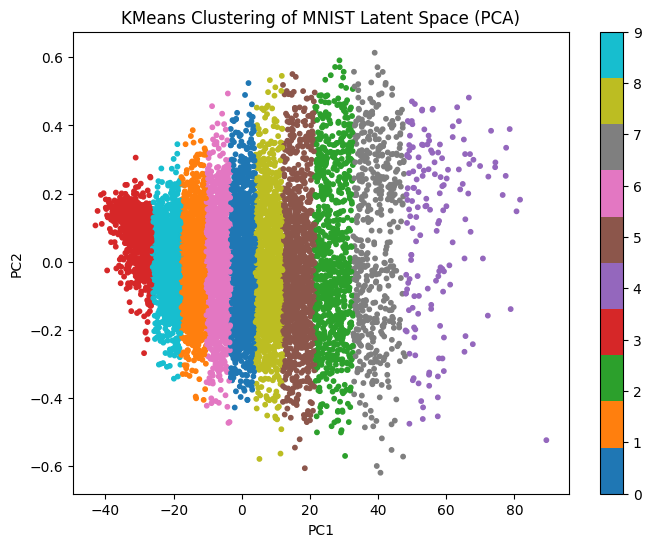

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=cluster_labels, cmap='tab10', s=10)
plt.title("KMeans Clustering of MNIST Latent Space (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
plt.show()
